In [12]:
# !wget https://pjreddie.com/media/files/yolov3.weights
!wget https://upload.wikimedia.org/wikipedia/commons/5/5c/Beagle_Dogs.jpg

--2022-10-15 14:38:48--  https://upload.wikimedia.org/wikipedia/commons/5/5c/Beagle_Dogs.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132715 (130K) [image/jpeg]
Saving to: 'Beagle_Dogs.jpg.3'

     0K .......... .......... .......... .......... .......... 38%  289K 0s
    50K .......... .......... .......... .......... .......... 77%  524K 0s
   100K .......... .......... .........                       100% 9.76M=0.3s

2022-10-15 14:38:49 (478 KB/s) - 'Beagle_Dogs.jpg.3' saved [132715/132715]



In [1]:
from PIL import Image
import os

im = Image.open('Beagle_Dogs.jpg')
im = im.resize((416, 416))
im = im.convert('RGB')
im.save('input.jpg')

after getting image, list them.

In [14]:
%ls

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 1A09-29B0

 c:\projects\notebook\5_yolo ���͸�

2022-10-15  ���� 02:38    <DIR>          .
2022-10-15  ���� 02:38    <DIR>          ..
2022-10-15  ���� 07:41           366,747 1_YOLO3_one_shot_keras.ipynb
2019-05-24  ���� 04:44           132,715 Beagle_Dogs.jpg
2019-05-24  ���� 04:44           132,715 Beagle_Dogs.jpg.1
2019-05-24  ���� 04:44           132,715 Beagle_Dogs.jpg.2
2019-05-24  ���� 04:44           132,715 Beagle_Dogs.jpg.3
2022-10-15  ���� 02:38            27,117 input.jpg
2022-10-15  ���� 02:07            56,816 input_detected.jpg
2018-03-25  ���� 01:49       248,007,048 yolov3.weights
               8�� ����         248,988,588 ����Ʈ
               2�� ���͸�  191,336,235,008 ����Ʈ ����


In [15]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import Add, concatenate
from keras.models import Model
import struct
import cv2
import tensorflow as tf
print(tf.__version__)

# CUDA 환경 설정.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

argparser = argparse.ArgumentParser(
    description='test yolov3 network with coco weights')

argparser.add_argument(
    '-w',
    '--weights',
    default='yolo3.weights',
    help='path to weights file')

argparser.add_argument(
    '-i',
    '--image',
    default='dog.jpg',
    help='path to image file')

2.9.1


_StoreAction(option_strings=['-i', '--image'], dest='image', nargs=None, const=None, default='dog.jpg', type=None, choices=None, help='path to image file', metavar=None)

In [16]:
# 학습 모델 가중치 로딩 클래스. 
# 사실, 앞에서 실습때 설명한 YOLOv1 네트워크 정의를 통해 모델 구현하는 방식과 유사함. 가중치 값들만 로딩하는 것이 다름.
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0



In [17]:
# bbox, objectness, classes 정의
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score



In [18]:
# 입력이미지를 주어진 net_h, net_w해상도인 레터박스로 변환
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

# 출력된 netout 텐서를 디코딩해 bbox 리스트 얻음
def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # netout은 (13,13,255)텐서크기임. grid_h, grid_w는 격자갯수 13임(1st scale).
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # (격자 H,격자 W,앵커박스, …)인 (13,13,3,85)텐서차원 변경
    nb_class = netout.shape[-1] - 5 # 마지막 텐서 차원에서 -5(bbox와 objectness)하면 클래스갯수 80임.

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2]) # bbox x, y 텐서 slicing (13,13,3,2). 모델 특징맵을 통해 계산된 x, y는 sig함수로 0-1로 정규화된 후 loss처리되는 값임.
    netout[..., 4:]  = _sigmoid(netout[..., 4:]) # objectness, classes 텐서 slicing (13,13,3,81)
    # objectness 텐서를 classes 텐서(80)과 곱함. objectness가 0이면 classes는 0이 됨.
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh # objectness threshold 이상일 경우에만, 예측된 classes 유효함.

    # [box][x,y,w,h,objectness,classes] 텐서임. Bbox별로 열거해 처리함.
    for i in range(grid_h*grid_w):
        row = i / grid_w    # grid_w=13. 격자 별 인덱스 계산
        col = i % grid_w    
        
        for b in range(nb_box): # 앵커박스 nb_box = 3 인 경우 3번 루프.
            # 앵커박스의 objectness 획득
            objectness = netout[int(row)][int(col)][b][4]
            # objectness가 objectness threshhold값 이하면 아래 로직 처리 안함.
            if(objectness.all() <= obj_thresh): continue    # https://numpy.org/doc/stable/reference/generated/numpy.all.html
            
            # 앵커박스의 텐서 0-3까지는 bbox x, y, w, h임. x, y는 각 격자의 상대좌표값임.
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # 격자 13x13 좌표계 기준으로 x, y값을 계산해 정규화(0-1)
            y = (row + y) / grid_h 
            w = anchors[2 * b + 0] * np.exp(w) / net_w # 모델을 통해 계산된 w는 exp함수 거친후 loss함수로 조정됨
            h = anchors[2 * b + 1] * np.exp(h) / net_h # 그러므로 exp계산후, w를 앵커 스케일 팩터와 곱하고 416 픽셀 해상도 기준 정규화(0-1) 
            
            # 클래스 확률(80개) 획득
            classes = netout[int(row)][col][b][5:]
            
            # x, y는 0-1로 정규화된 격자 중심좌표임. w/2, h/2를 계산해, xmin, ymin, xmax, ymax를 얻음.
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

# 모델에서 계산된 boxex를 실제 image 해상도에 맞춰 위치, 크기를 조정함. 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
# 비최대억제 알고리즘 수행
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# bbox 그림                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,0,255), 1)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,0,255), 1)
        
    return image      


In [19]:
# conv block. resnet 개념 적용.
def _conv_block(inp, convs, skip=True):
    # _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
    #                              {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1}])
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x   # 4 layer 인 경우, 마지막 2번째 레이어는 직접 연결. ResNet.
        count += 1
                                    # https://keras.io/api/layers/reshaping_layers/zero_padding2d/
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # darknet에서는 left, top에 zero padding함 
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', 
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return Add()([skip_connection, x]) if skip else x       # https://keras.io/api/layers/merging_layers/add/

# IoU 계산 함수들
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

# YOLOv3 모델 생성
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x     # skip layer 설정. 97 레이어와 연접됨.
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x     # skip layer, 85 레이어와 연접됨.
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)              # https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D
                                        # https://towardsdatascience.com/deep-learning-and-transfer-learning-31c6394b10c5
    x = concatenate([x, skip_61])       # https://keras.io/api/layers/merging_layers/concatenate/

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model



In [20]:

def _main_(args):
    weights_path = args.weights
    image_path   = args.image

    # set some parameters
    net_h, net_w = 416, 416
    obj_thresh, nms_thresh = 0.5, 0.45
    anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

    # make the yolov3 model to predict 80 classes on COCO
    yolov3 = make_yolov3_model()

    # load the weights trained on COCO into the model
    weight_reader = WeightReader(weights_path)
    weight_reader.load_weights(yolov3)

    # preprocess the image
    image = cv2.imread(image_path)
    image_h, image_w, _ = image.shape
    new_image = preprocess_input(image, net_h, net_w)

    # run the prediction
    yolos = yolov3.predict(new_image)
    boxes = []

    for i in range(len(yolos)):
        # decode the output of the network
        boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

    # correct the sizes of the bounding boxes
    correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

    # suppress non-maximal boxes
    do_nms(boxes, nms_thresh)     

    # draw bounding boxes on the image using labels
    draw_boxes(image, boxes, labels, obj_thresh) 
 
    # write the image with bounding boxes to file
    cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 



In [21]:
args = argparser.parse_args(['-w', './yolov3.weights', '-i', 'input.jpg'])
_main_(args)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

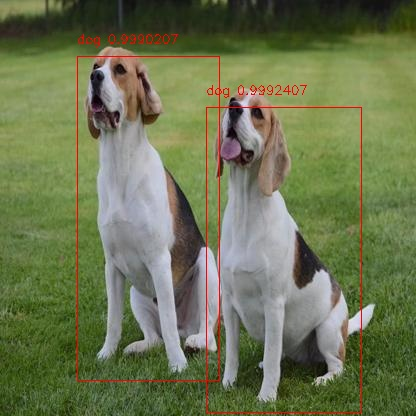

In [22]:
from PIL import Image
import os

im = Image.open('input_detected.jpg')
im